In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import time
from scipy.stats import laplace, norm
from scipy.optimize import curve_fit
import scipy

In [4]:
data_fits = pd.read_csv("../../csvs/Res_3_feats/Weibull_Parameters_101.csv")

In [5]:
data_fits.head()

,ID,Gamma,Location,Alpha
0,0.0,2.666553,2.857718,1.047987e+00
1,1.0,1.000000,8.000000,2.797762e-15
2,2.0,0.999930,8.000000,1.064659e-14
3,3.0,2.861311,6.006627,9.342724e-01
4,4.0,1.465059,5.357733,3.657005e-01


In [62]:
#drop all with location at 8, as those are the stable systems
trimmed_data_fits=data_fits[(data_fits["Location"]<7.99) & (data_fits["Location"]>0)]
print(trimmed_data_fits.shape)
#trimmed_data_fits= trimmed_data_fits.reset_index(drop=True)
trimmed_data_fits.head()

(68, 4)


,ID,Gamma,Location,Alpha
0,0.0,2.666553,2.857718,1.047987
3,3.0,2.861311,6.006627,0.934272
4,4.0,1.465059,5.357733,0.365700
5,5.0,2.471109,4.724218,1.206824
7,7.0,2.449564,3.080913,0.772254


In [63]:
def weib(loc, loc_fixed, gamma, alpha, x):
    #assume x is log t
    prob = (gamma/alpha)* ((loc-loc_fixed)/alpha)**(gamma-1.) * np.exp(-((loc-loc_fixed)/alpha)**gamma)
    dist = (gamma/alpha)* ((x-loc)/alpha)**(gamma-1.) * np.exp(-((x-loc)/alpha)**gamma)
    return prob*dist

In [64]:
#need to do a double integral
#x must be an ARRAY
def weib_pdf(x, loc,  gamma, alpha):
    #assume x is log t
    problematic = np.where(x<loc)[0]
    fine = np.where(x>loc)[0]
    prob = np.zeros_like(x)
    prob[fine] = (gamma/alpha)* ((x[fine]-loc)/alpha)**(gamma-1.) * np.exp(-((x[fine]-loc)/alpha)**gamma)
    prob[problematic]=0.
    return prob

In [65]:
#need to do a double integral
#x can be int or aray, but has poor error handling
def weib_pdf_val(x, loc,  gamma, alpha):
    #assume x is log t  
    prob = (gamma/alpha)* ((x-loc)/alpha)**(gamma-1.) * np.exp(-((x-loc)/alpha)**gamma)
    #print prob[fine]
    return prob

In [66]:
# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [76]:
start = time.time()
info = np.zeros((trimmed_data_fits.shape[0], 7)) # add norm const, RMS
corrupted = []

#print trimmed_data_fits.index

for index_val in range(int(trimmed_data_fits.shape[0])):
    width = 200 #incremental step

    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot("121")
    ax2 = fig.add_subplot("122")
    
    print index_val
    #print(trimmed_data_fits.iloc[1]["Gamma"])
    gamma = trimmed_data_fits.iloc[index_val]["Gamma"]
    alpha = trimmed_data_fits.iloc[index_val]["Alpha"]
    loc = trimmed_data_fits.iloc[index_val]["Location"]
    #print gamma, alpha, loc
    #print "Spread", alpha
    #print gamma, alpha, loc, x 
    vals= np.linspace(loc-alpha*sigma_width, loc+alpha*sigma_width, width)
    exp_val = alpha* scipy.special.gamma(1+1./gamma)
    #print loc +exp_val
    final_y  = np.zeros(width)
    for i in range(int(vals.shape[0])):
        bins = np.linspace(loc-alpha*sigma_width , loc+sigma_width*alpha, width)
        val1 = vals[i]
        #get the entire pdf
        prob = weib_pdf_val(val1, loc - exp_val, gamma, alpha)
        #get the probability that time being drawn
        y = prob*weib_pdf(bins, val1,gamma, alpha)
        ax.plot(bins, y)#just to prevent any errors
        final_y = np.nansum(np.asarray([y, final_y]), axis = 0)  #np.nansum(a=[y, final_y], axis= 1)
    #plt.figure(figsize=(12, 8))
    ax2.plot(bins, final_y)    
    p0 = [1., loc+alpha*scipy.special.gamma(1+ 1./gamma), alpha] #norm, mean, sigma
    #popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])
    try:
        coeff, var_matrix = scipy.optimize.curve_fit(gauss, bins, final_y, p0=p0)
        #print var_matrix
        perr = np.sqrt(np.diag(var_matrix))
        plt_title = 'Convolution Parameters For System {4}: Mean: {0:.5} E {2:.4}   Sigma: {1:.5} E: {3:.4}'.format(coeff[1], np.abs(coeff[2]), perr[1], perr[2], trimmed_data_fits.index[index_val])
        #print "Coefs: Mean, Sigma", coeff[1:], "Error", perr[1:]
        #fit can cbe calculated
        delta_t = (( loc+sigma_width*alpha) -loc - 0.0001)/(width-1)
        summed_fit_area_weib=0
        summed_fit_area_gauss = 0


        ###########################Error calcualtion###############################
    
        # Get the fitted curve
        hist_fit = gauss(bins, *coeff)


        #find the total sum of final_y to find normalizing constant
        summed_fit_area_weib = np.sum(final_y)*delta_t
        summed_fit_area_gauss = np.sum(hist_fit)*delta_t


        overlapp = np.concatenate([(final_y/summed_fit_area_weib).reshape(width,1), 
                                   (hist_fit/summed_fit_area_gauss).reshape(width, 1)], axis = 1)
        #define IOU as the sum, of their overlap, so take the min of both and sum it multiplied by delta t 
        IOU = overlapp.min(axis = 1).sum()*delta_t
        #overlapped area
        print IOU, trimmed_data_fits.index[index_val]

        ###########################################################################   
        info[index_val] = [trimmed_data_fits.index[index_val], coeff[0], coeff[1], perr[1], coeff[2], perr[2], IOU]

    except Exception as e:
        print e
        corrupted.append(trimmed_data_fits.index[index_val] )
        info[index_val] = [trimmed_data_fits.index[index_val],np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
        plt_title = 'Convolution Parameters For System {0}'.format(trimmed_data_fits.index[index_val])
    
    
    
    
    
    plt.suptitle(plt_title)
    #plt.show()
    plt.savefig("../../Figures/ResonantFigures/{0}.png".format(trimmed_data_fits.index[index_val]))
    plt.close()
    #print sub_short.index[index_val]
    #break
    #hist_fit = gauss(bins, *coeff)
    #plt.plot(bins, hist_fit/summed_fit_area_gauss)
    #plt.plot(bins, final_y/summed_fit_area_weib)
    #print info[index_val]
    #break
end = time.time()
print end-start


0


/home/naireen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


0.9802128633546844 0
1
0.9854152601906437 3
2
0.915517290046057 4
3
0.9741463630717231 5
4
0.9734189917156182 7
5
0.9838274380949915 8
6
0.9811310250659828 10
7
0.9938982849701622 11
8
0.9337982853387361 13
9
0.9932990589430377 14
10
0.9580797396398536 15
11
0.9783216875497102 16
12
0.9880069890260779 19
13
0.9836154723666777 20
14
0.9715212588360244 22
15
0.8979400847483809 23
16
0.9849861096650772 25
17
0.9868797994433476 26
18
0.9821576608431103 27
19
0.9777432457760342 28
20
0.9800090544483668 30
21
0.9878784015629448 31
22
0.9434567477219907 33
23
0.9923337123822641 34
24
0.9188685248816749 36
25
0.9844850387054144 37
26
0.9689889698146145 38
27
0.9910188398751454 41
28
0.9238404865131488 42
29
0.9412716215737833 43
30
0.9511937958100781 46
31
0.9703886165648424 47
32
0.9754469987633575 48
33
0.7731475335723272 49
34
0.9789545878953951 50
35
0.9688853456782208 53
36
0.9506659081174735 54
37
0.9440084390694424 55
38
0.9674052220516286 58
39
0.9340446918113522 59
40
0.87688522063298

In [77]:
corrupted

[]

In [102]:
info_frame = pd.DataFrame(info, columns=["ID", "Norm","Mean" , "Mean_Error", "Sigma", "Error", "IOU"])
print info_frame.shape
info_frame.to_csv("../../csvs/Res_3_feats/Convolved_Params_{0}_IOU.csv".format(info_frame.shape[0]), index=False)
info_frame.head()

(68, 7)


,ID,Norm,Mean,Mean_Error,Sigma,Error,IOU
0,0.0,17.579000,3.761504,0.001761,0.541129,0.001761,0.980213
1,3.0,23.465416,6.822150,0.001102,0.454880,0.001102,0.985415
2,4.0,88.045595,5.622223,0.004265,0.302330,0.004265,0.915517
3,5.0,12.440545,5.750126,0.002811,0.663568,0.002811,0.974146
4,7.0,30.160825,3.736249,0.001863,0.427685,0.001863,0.973419


(68, 7)


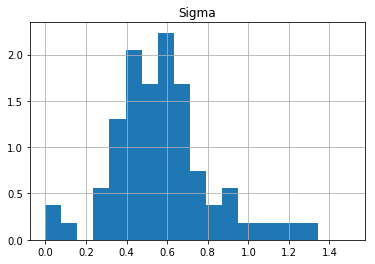

0.01383260573661006 1.2981958927650123
['ID' 'Norm' 'Mean' 'Mean_Error' 'Sigma' 'Error' 'IOU']


In [103]:
valid_info_frame = info_frame[~info_frame["ID"].astype(int).isin(corrupted)]

print valid_info_frame.shape
valid_info_frame["Sigma"] = np.abs(valid_info_frame["Sigma"])
bins = np.linspace(0, 1.5, 20)
valid_info_frame.hist("Sigma",  normed = 1, bins = bins)
plt.show()
print valid_info_frame["Sigma"].min(), valid_info_frame["Sigma"].max()
print valid_info_frame.columns.values

Average Sigma 0.5722791554969378 Std in Sigma 0.2395581511072143


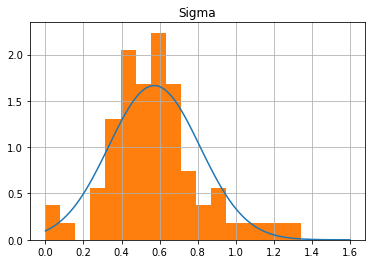

In [104]:
from scipy.stats import norm

mu_fit, sig_fit =  norm.fit(valid_info_frame["Sigma"].values)
print "Average Sigma", mu_fit, "Std in Sigma", sig_fit
#x, xmax = plt.xlim()
fig = plt.figure()
ax = fig.add_subplot("111")
x = np.linspace(0, 1.6, 100)
p = norm.pdf(x, mu_fit, sig_fit)
plt.plot(x, p)
valid_info_frame.hist("Sigma", normed = 1, ax = ax, bins = bins)
#old_valid_info_frame.hist("Sigma", normed = 1, ax = ax, bins = bins)
#print valid_info_frame.shape
plt.show()


0.6609767886492558
Empty DataFrame
Columns: [ID, Norm, Mean, Mean_Error, Sigma, Error, IOU]
Index: []


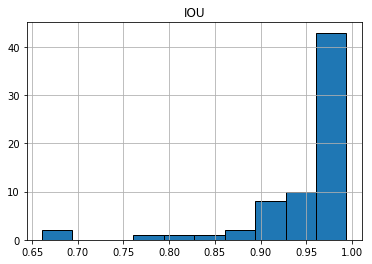

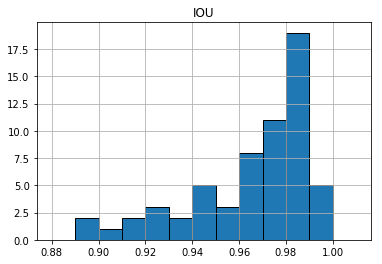

In [105]:
bins = np.linspace(0.88,1.01, 14)
#print valid_info_frame[valid_info_frame["IOU"] < 0.9]
valid_info_frame.hist("IOU", edgecolor = "black", linewidth = 1)
print valid_info_frame["IOU"].min()
print valid_info_frame[valid_info_frame["IOU"] < .1]
valid_info_frame.hist("IOU", edgecolor = "black", linewidth = 1, bins = bins)
plt.show()

In [112]:
#compare the two sigma hists
old_valid_info_frame= pd.read_csv("../../Figures/ConvolutedFigures/Convolved_Params_266_IOU_fixed.csv")
print old_valid_info_frame.shape
old_valid_info_frame= old_valid_info_frame[(old_valid_info_frame["Mean"]!=np.inf) & (np.abs(old_valid_info_frame["Sigma"]<10)) & (old_valid_info_frame["Mean"]>4) & (old_valid_info_frame["Mean"]<9)] #need to see what causes this
old_valid_info_frame = old_valid_info_frame[old_valid_info_frame["ID"]!=1364]
#print valid_info_frame.max(axis = 0), valid_info_frame.min(axis = 0)
#valid_info_frame.head()
print old_valid_info_frame.shape

(266, 7)
(246, 7)


Average Sigma 0.6080076715519274 Std in Sigma 0.2558534366263032
Average Sigma 0.5722791554969378 Std in Sigma 0.2395581511072143


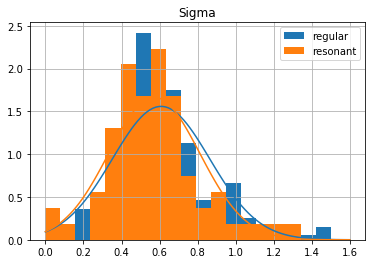

In [131]:
old_valid_info_frame["Sigma"] = np.abs(old_valid_info_frame["Sigma"])
#bins = np.linspace(0, 1.5, 20)

fig = plt.figure()
ax = fig.add_subplot("111")

x = np.linspace(0, 1.6, 100)
mu_fit, sig_fit = norm.fit(old_valid_info_frame["Sigma"].values)
print "Average Sigma", mu_fit, "Std in Sigma", sig_fit

p = norm.pdf(x, mu_fit, sig_fit)
figs = plt.plot(x, p)
#print(figs[-1].get_color())
old_valid_info_frame.hist("Sigma",  normed = 1, bins = bins, ax = ax, label = "regular", color = figs[-1].get_color())

mu_fit, sig_fit = norm.fit(valid_info_frame["Sigma"].values)
print "Average Sigma", mu_fit, "Std in Sigma", sig_fit
p = norm.pdf(x, mu_fit, sig_fit)
figs = plt.plot(x, p)
valid_info_frame.hist("Sigma", normed = 1, bins = bins, ax = ax, label = "resonant", color = figs[-1].get_color())
plt.legend()
plt.show()
#print old_valid_info_frame["Sigma"].min(), old_valid_info_frame["Sigma"].max()

#print valid_info_frame.columns.values